# Librerias a importar

## Se instalan las dependecias si no las tenemos

In [1]:
# !pip3 install --upgrade wandb
# !pip install scikit-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sklearn
import os
import time

2025-09-28 04:04:39.230206: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-28 04:04:39.259319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-28 04:04:40.291453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

## Nos registramos en WANDB para guardar los experimentos

In [4]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

wandb: Currently logged in as: luisedu04 (luisedu04-buap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Se definen los híper-parámetros a usar

In [5]:
lr = 0.005 #Learning rate
epochs = 1000
bs = 200 #batch size
loss = "mse"
optimizer = "RMSprop"
regularizer = "L2"
NNL1 = 256
NNL2 = 128
NNL3 = 64

In [6]:
run = wandb.init(
    settings=wandb.Settings(x_disable_stats=False, x_stats_sampling_interval = 1.0),
    # set the wandb project where this run will be logged
    name = "Intento_intento_con_muchas_mas_epocas",
    project = "Creacion_de_regresion_lineal",
    group = "Pol",

    # track hyperparameters and run metadata with wandb.config
    config = {
        "layer_1": NNL1,
        "layer_2": NNL2,
        "layer_3": NNL3,
        "layer_4": 1,
        "activation": "relu",
        "activation_3": "tanh",
        "w_initializer": "He Initialization",
        "optimizer": optimizer,
        "loss": loss,
        "metric": "mse",
        "epoch": epochs,
        "batch_size": bs,
        "layer_quantity": 1,
        "regularizer": regularizer,
        "Modelo": "Pol"
    }
)
time.sleep(3.0)

# Preparando la red neuronal (Recolección de datos y preprocesamiento)

## Reciclamos un modulo para hacer el polinomio

In [7]:
class PolynomialTransform(tf.keras.layers.Layer):
    def __init__(self, degree):
        super(PolynomialTransform,self).__init__()
        
        self.num_outputs = degree + 1 #Se define la cantidad de potencias con las que se trabajara (incluido el 0)
        self.powers =  tf.range(start = 0.0, limit = self.num_outputs) #Se crea el array de potencias 
        
    def poly_terms(self, inputs):
        #Garantizamos que se aplique a cualquier dato, array o no
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs=(inputs,)
        elif (len(inputs.shape)==1):
            inputs=tf.expand_dims(inputs, axis=1)
       
        #Sacamos la longitud del batch para conseguir la matriz de potencias
        batch = tf.shape(inputs)[0]

        #Expandimos los array de entrada y de potencias para que sean compatibles
        inputs_expanded = tf.expand_dims(inputs, axis=-1)  #[batch, 1, 1]
        powers_expanded = tf.expand_dims(self.powers, axis=0)  #[1, num_outputs]
        powers_expanded = tf.expand_dims(powers_expanded, axis=0)  #[1, 1, num_outputs]
    
        poly_terms = tf.math.pow(inputs_expanded, powers_expanded)  #[batch, 1, num_outputs]
        poly_terms = tf.squeeze(poly_terms, axis=1)  #[batch, num_outputs]
        return poly_terms

    def call (self, inputs, coefficients):
        terms = self.poly_terms(inputs)
        coefficients = tf.convert_to_tensor(coefficients, dtype=tf.float32)
        coefficients = tf.reshape(coefficients, [self.num_outputs])  
        return tf.tensordot(terms, coefficients, 1) #[batch] --> batch_i = a_i*(x**i)

## Definimos la función que queremos usar

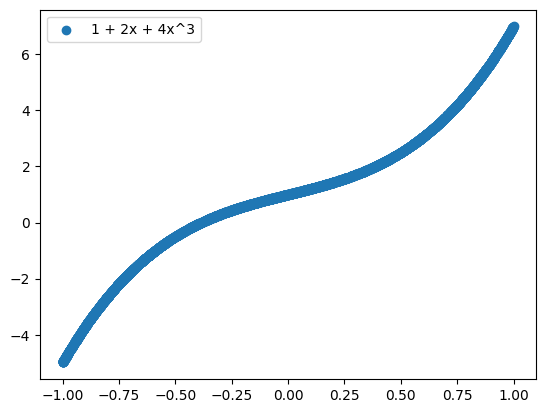

In [8]:
batch_size = 5000
Polynomial = PolynomialTransform(3)
x = tf.random.uniform((batch_size,), minval=-1.0, maxval=1.0)
y = Polynomial(x, coefficients = [1,2,0,4])
plt.scatter(x, y, label = "1 + 2x + 4x^3")
plt.legend()

## Creamos los datos que va a recibir la red neuronal

In [9]:
domain = tf.reshape(x,[-1,1])
codomain_pol = tf.reshape(y,[-1,1])
domain = domain.numpy()
codomain_pol = codomain_pol.numpy()
X_train, X_test, y_train, y_test = train_test_split(domain, codomain_pol, test_size=0.2, random_state=42)

## Escalamos los datos (estandarización)

In [10]:
scale_x_pol = StandardScaler()
scale_y_pol = StandardScaler()
X_train, y_train = scale_x_pol.fit_transform(X_train), scale_y_pol.fit_transform(y_train)
X_test, y_test = scale_x_pol.transform(X_test), scale_y_pol.transform(y_test)

# Creación de la red neuronal

In [11]:
entrada = 1
stddev1 = np.sqrt(2/entrada)
stddev2 = np.sqrt(2/NNL1)
model_pol = keras.Sequential(
    [
        layers.Dense(NNL1, activation = "relu", name = "layer1", 
                     kernel_initializer=initializers.RandomNormal(stddev = stddev1),
                     kernel_regularizer=regularizers.L2(l2=1e-5),
                    ),
        Dropout(0.2),        
        layers.Dense(NNL2, activation = "tanh", name = "layer2", 
                     kernel_initializer=initializers.RandomNormal(stddev = stddev2),
                     kernel_regularizer=regularizers.L2(l2=1e-5),
                    ),
        Dropout(0.2),
        layers.Dense(1),
            ]
) #Arquitectura de la red neuronal

model_pol.build(input_shape=(None, entrada))
model_pol.compile(loss = loss, optimizer = Adam(learning_rate = lr),metrics = ["mse"]) #Función de costo
model_pol.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

## Reset ANN if needed

In [12]:
# for layer in model_pol.layers:
#    if hasattr(layer, 'kernel_initializer'):
#        new_weights = layer.kernel_initializer(layer.kernel.shape)
#        layer.kernel.assign(new_weights)
#    if hasattr(layer, 'bias_initializer') and layer.bias is not None:
#        new_bias = layer.bias_initializer(layer.bias.shape)
#        layer.bias.assign(new_bias)

## Model History

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                               min_delta = 0.001,
                               patience=100, 
                               restore_best_weights=True,
                               mode = "auto",
                               verbose = 1,
                               baseline = None)

history = model_pol.fit(X_train, y_train,
                    batch_size = bs,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test),
                    callbacks=[
                        WandbMetricsLogger(log_freq=1),
                        WandbModelCheckpoint("models/model_pol_data.keras"),
                        early_stopping
                    ]
                            )
run.finish()

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.4164 - mse: 1.4088 - val_loss: 0.4533 - val_mse: 0.4457
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4401 - mse: 0.4324 - val_loss: 0.1605 - val_mse: 0.1528
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3096 - mse: 0.3020 - val_loss: 0.1402 - val_mse: 0.1326
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2622 - mse: 0.2546 - val_loss: 0.1703 - val_mse: 0.1627
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2335 - mse: 0.2260 - val_loss: 0.1130 - val_mse: 0.1055
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2022 - mse: 0.1947 - val_loss: 0.1035 - val_mse: 0.0960
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1743 - mse: 0.1668 - val_loss: 0.1436 - val_mse: 0.1361
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1485 - mse: 0.1411 - val_loss: 0.1111 - val_mse: 0.1037
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/

batch/batch_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▅▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/mse,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mse,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,██▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mse,█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/batch_step,7739


# Graficamos las funciones

In [14]:
x_validation = np.linspace(-1, 1, 1000).reshape(-1, 1)
x_validation = scale_x_pol.transform(x_validation)
prediction = model_pol.predict(x_validation)
prediction = scale_y_pol.inverse_transform(prediction)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


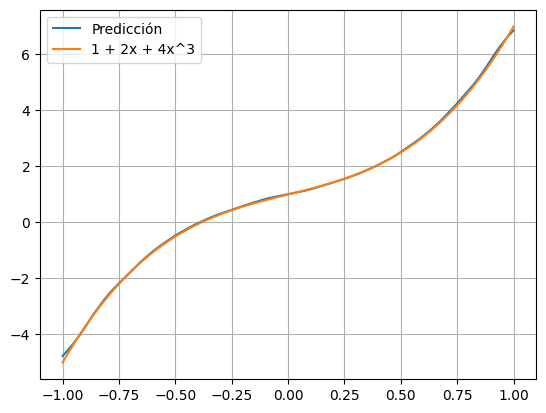

In [15]:
x_validation = np.linspace(-1, 1, 1000).reshape(-1, 1)
plt.plot(x_validation, prediction, label = "Predicción")
plt.plot(x_validation, Polynomial(x_validation, coefficients = [1,2,0,4]) , label = "1 + 2x + 4x^3")
plt.legend()
plt.grid()
plt.show()